# VLM Navigation Test
测试基于当前agent流程的VLM导航决策

流程：
1. 加载RGBD图像和相机位姿数据
2. 可视化可导航区域（基于障碍物高度范围）
3. 使用NavAgent进行RGB标注（生成带箭头和动作编号的可视化图像）
4. 使用当前的VLM调用prompt进行测试

In [1]:
import sys
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image

# 添加当前目录到路径
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

from nav_agent import NavAgent
from vlm import OpenAIVLM
from utils import depth_to_height

## 1. 加载测试数据
从pickle文件加载RGBD图像和相机位姿

In [2]:
# 从pickle文件加载
data_path = './test_data.pkl'
print(f"从pickle文件加载数据: {data_path}")
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# 显示pkl文件中的所有字段
print(f"\nPickle文件包含的字段:")
for key in data.keys():
    if hasattr(data[key], 'shape'):
        print(f"  {key}: {data[key].shape} ({data[key].dtype})")
    else:
        print(f"  {key}: {type(data[key]).__name__} = {data[key]}")

# 构造obs字典（与agent期望的格式一致）
# 注意：pkl中的rgb可能是BGR格式，需要转换为RGB
rgb_data = data['rgb']
if rgb_data.shape[-1] == 3:
    # 如果是BGR格式，转换为RGB
    rgb_data = cv2.cvtColor(rgb_data, cv2.COLOR_BGR2RGB)

obs = {
    'rgb': rgb_data,
    'depth': data['depth'],
    'intrinsic': data['intrinsic'],
    'extrinsic': data['extrinsic'],  # T_cam_odom (odom->cam)
    'base_to_odom_matrix': data['base_to_odom_matrix']  # T_odom_base (base->odom)
}

print(f"\n✓ 数据加载成功")
print(f"  RGB shape: {obs['rgb'].shape}")
print(f"  Depth shape: {obs['depth'].shape}")
print(f"  Intrinsic shape: {obs['intrinsic'].shape}")
print(f"  Extrinsic shape: {obs['extrinsic'].shape}")
print(f"  Base pose shape: {obs['base_to_odom_matrix'].shape}")

从pickle文件加载数据: ./test_data.pkl

Pickle文件包含的字段:
  rgb: (540, 960, 3) (uint8)
  depth: (540, 960) (float32)
  intrinsic: (3, 3) (float32)
  extrinsic: (4, 4) (float32)
  base_to_odom_matrix: (4, 4) (float32)
  camera_frame: str = camera_head_left_link
  base_frame: str = base_link
  odom_frame: str = odom
  timestamp: str = 2025-12-22T17:13:26.115903
  rgb_topic: str = /hdas/camera_head/rgb/image_rect_color
  depth_topic: str = /hdas/camera_head/depth/depth_registered

✓ 数据加载成功
  RGB shape: (540, 960, 3)
  Depth shape: (540, 960)
  Intrinsic shape: (3, 3)
  Extrinsic shape: (4, 4)
  Base pose shape: (4, 4)


## 2. 显示原始RGB图像

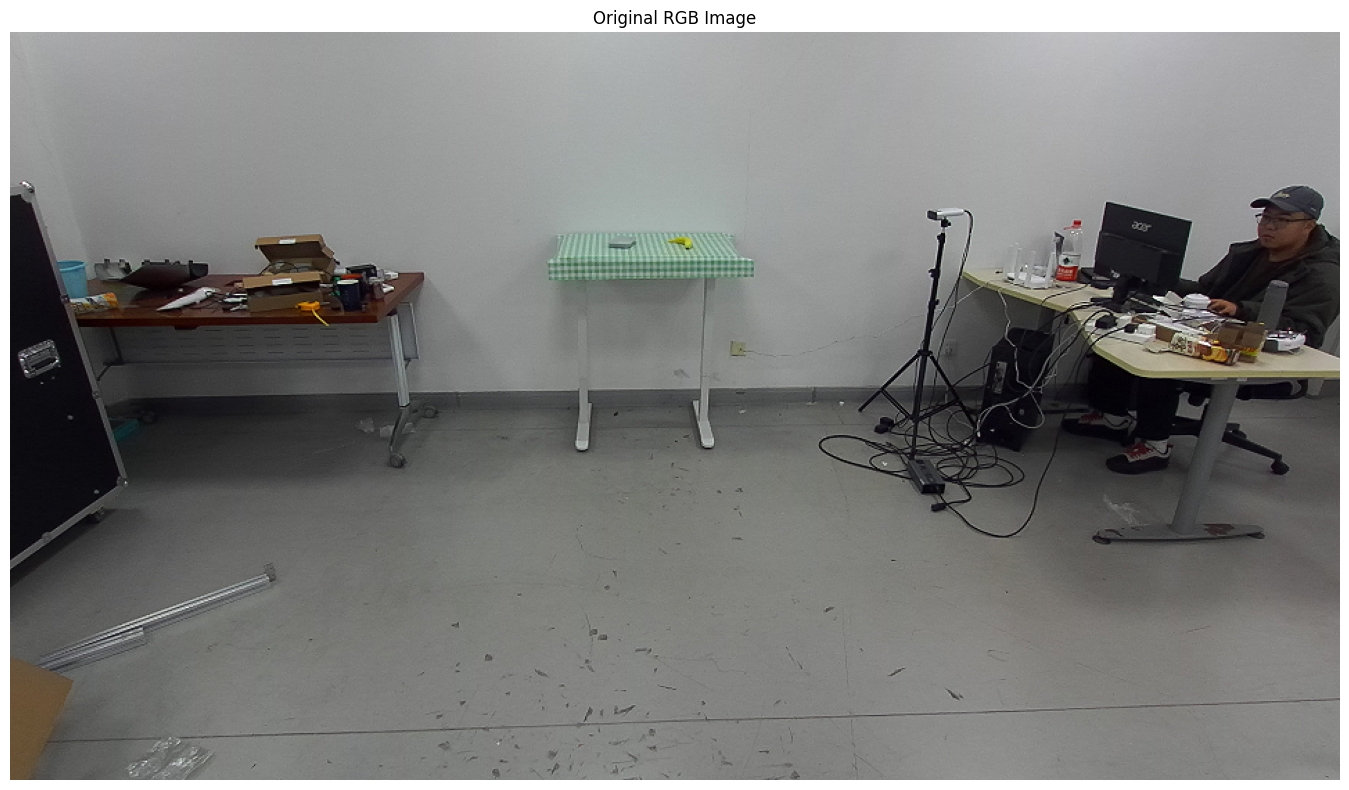

In [3]:
plt.figure(figsize=(15, 8))
plt.imshow(obs['rgb'])
plt.title("Original RGB Image")
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. 初始化NavAgent
配置导航参数和VLM设置

In [4]:
# 初始化NavAgent
cfg = {
    # Navigation parameters
    'num_theta': 40,
    'image_edge_threshold': 0.04,
    'clip_dist': 5.0,
    'vlm_history_length': 3,
    'turn_angle_deg': 30.0,
    
    # Navigability configuration (障碍物高度范围)
    'obstacle_height_min': 0.0,  # 最小障碍物高度（米）
    'obstacle_height_max': 2.0,   # 最大障碍物高度（米）
    # 说明：高度在[0.15m, 2.0m]区间内的点被视为障碍物（如桌子、椅子、墙壁）
    #       低于0.15m的是地面（可通行），高于2.0m的是天花板（可通行）
    
    # VLM configuration (可自定义)
    'vlm_model': 'qwen3-vl-8b-instruct',
    'vlm_api_key': 'sk-83be1f30087144a2a901f8f060ccf543',
    'vlm_base_url': 'https://dashscope.aliyuncs.com/compatible-mode/v1',
    'vlm_timeout': 10
}

# 'vlm_model': '/data/sea_disk0/liujy/models/Qwen/Qwen3-VL-8B-Instruct/',
# 'vlm_api_key': 'EMPTY',
# 'vlm_base_url': 'http://10.15.89.71:34134/v1/',

agent = NavAgent(cfg=cfg)

# 设置导航目标
goal = "banana"  # 修改为你的目标物体
goal_description = ""  # 可选的目标描述

# 重置agent（这会初始化VLM的完整任务说明）
agent.reset(goal=goal, goal_description=goal_description)

print(f"✓ NavAgent初始化完成")
print(f"  目标: {goal}")
print(f"  转向角度: {cfg['turn_angle_deg']}°")
print(f"  VLM历史长度: {cfg['vlm_history_length']} rounds")
print(f"\n障碍物高度范围: [{cfg['obstacle_height_min']}m, {cfg['obstacle_height_max']}m]")
print(f"\nVLM配置:")
print(f"  模型: {cfg['vlm_model']}")
print(f"  API地址: {cfg['vlm_base_url']}")
print(f"  超时时间: {cfg['vlm_timeout']}秒")

[NavAgent] Reset without goal, VLM history cleared
[NavAgent] Reset with goal='banana', VLM initialized with full task briefing
✓ NavAgent初始化完成
  目标: banana
  转向角度: 30.0°
  VLM历史长度: 3 rounds

障碍物高度范围: [0.0m, 2.0m]

VLM配置:
  模型: qwen3-vl-8b-instruct
  API地址: https://dashscope.aliyuncs.com/compatible-mode/v1
  超时时间: 10秒


## 4. 可视化可导航区域（Navigability Mask）

计算可导航性mask...
✓ Navigability mask计算完成
  Mask shape: (540, 960)
  可通行像素: 232110 (44.8%)
  障碍物像素: 286290 (55.2%)

障碍物高度范围: [0.0m, 2.0m]


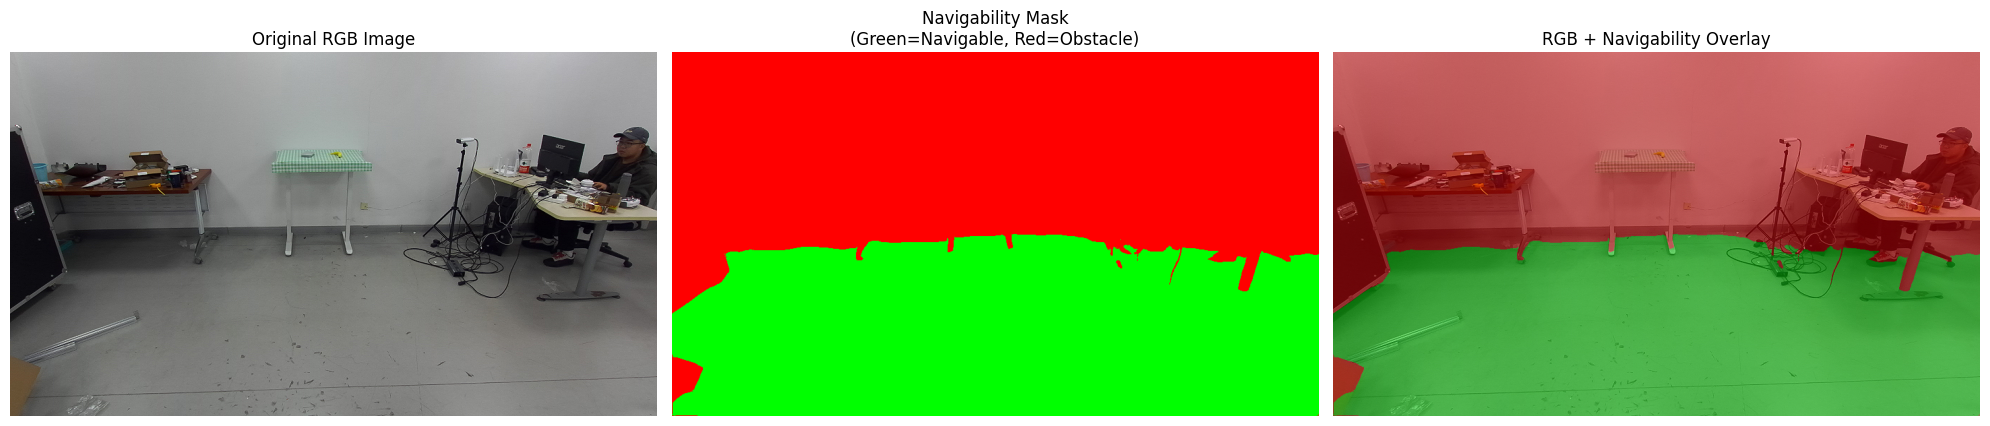


高度统计（odom坐标系）:
  最小高度: -0.162m
  最大高度: 1.841m
  平均高度: 0.472m
  中位数高度: 0.124m


In [5]:
# 计算可导航性mask
print("计算可导航性mask...")
navigability_mask = agent._get_navigability_mask(
    obs['depth'], 
    obs['intrinsic'], 
    obs['extrinsic']
)

print(f"✓ Navigability mask计算完成")
print(f"  Mask shape: {navigability_mask.shape}")
print(f"  可通行像素: {np.sum(navigability_mask)} ({np.sum(navigability_mask)/navigability_mask.size*100:.1f}%)")
print(f"  障碍物像素: {np.sum(~navigability_mask)} ({np.sum(~navigability_mask)/navigability_mask.size*100:.1f}%)")
print(f"\n障碍物高度范围: [{cfg['obstacle_height_min']}m, {cfg['obstacle_height_max']}m]")

# 可视化navigability mask
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. 原始RGB图像
axes[0].imshow(obs['rgb'])
axes[0].set_title('Original RGB Image')
axes[0].axis('off')

# 2. Navigability mask（绿色=可通行，红色=障碍物）
nav_vis = np.zeros((*navigability_mask.shape, 3), dtype=np.uint8)
nav_vis[navigability_mask] = [0, 255, 0]  # 绿色 = 可通行
nav_vis[~navigability_mask] = [255, 0, 0]  # 红色 = 障碍物
axes[1].imshow(nav_vis)
axes[1].set_title(f'Navigability Mask\n(Green=Navigable, Red=Obstacle)')
axes[1].axis('off')

# 3. 叠加显示
overlay = obs['rgb'].copy()
alpha = 0.4
overlay[navigability_mask] = (overlay[navigability_mask] * (1-alpha) + 
                               np.array([0, 255, 0]) * alpha).astype(np.uint8)
overlay[~navigability_mask] = (overlay[~navigability_mask] * (1-alpha) + 
                                np.array([255, 0, 0]) * alpha).astype(np.uint8)
axes[2].imshow(overlay)
axes[2].set_title('RGB + Navigability Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 显示高度统计
height_map = depth_to_height(obs['depth'], obs['intrinsic'], obs['extrinsic'])
valid_heights = height_map[np.isfinite(height_map)]

print(f"\n高度统计（odom坐标系）:")
print(f"  最小高度: {np.min(valid_heights):.3f}m")
print(f"  最大高度: {np.max(valid_heights):.3f}m")
print(f"  平均高度: {np.mean(valid_heights):.3f}m")
print(f"  中位数高度: {np.median(valid_heights):.3f}m")

## 5. 生成可导航动作并标注图像

In [6]:
# Step 1: 计算可导航性
print("[1/3] 计算可导航性...")
a_initial = agent._navigability(obs)
print(f"  ✓ 初始方向数: {len(a_initial)}")

# Step 2: 提议动作
print("[2/3] 提议动作...")
a_final = agent._action_proposer(a_initial, obs['base_to_odom_matrix'])
print(f"  ✓ 最终动作数: {len(a_final)}")

# Step 3: 投影到图像（生成标注）
print("[3/3] 投影到图像...")
a_final_projected, rgb_vis = agent._projection(a_final, obs)
print(f"  ✓ 可见动作数: {len(a_final_projected)}")
print(f"  动作映射: {a_final_projected}")
print(f"\n说明:")
print(f"  - 红色箭头: 前进动作 (编号 1, 2, 3, ...)")
print(f"  - 左侧 '-1': 左转 {cfg['turn_angle_deg']}°")
print(f"  - 右侧 '-2': 右转 {cfg['turn_angle_deg']}°")

[1/3] 计算可导航性...
  ✓ 初始方向数: 31
[2/3] 提议动作...


  ✓ 最终动作数: 7
[3/3] 投影到图像...
[DEBUG] Projected action 1: r=3.92m, waypoint_r=3.13m, theta=-30.4°, px=(762, 379)
[DEBUG] Projected action 2: r=3.71m, waypoint_r=2.96m, theta=-17.6°, px=(636, 368)
[DEBUG] Projected action 3: r=3.81m, waypoint_r=3.04m, theta=-4.8°, px=(526, 352)
[DEBUG] Projected action 4: r=3.62m, waypoint_r=2.90m, theta=11.2°, px=(393, 367)
[DEBUG] Projected action 5: r=3.69m, waypoint_r=2.95m, theta=24.0°, px=(278, 380)
[DEBUG] Projected action 6: r=4.16m, waypoint_r=3.33m, theta=36.8°, px=(138, 382)
[DEBUG] _project_onto_image: 7 actions from _action_proposer, 6 projected, 1 skipped by _can_project
  ✓ 可见动作数: 6
  动作映射: {(3.916941770018569, -0.5308218785733134): 1, (3.7051149390426783, -0.30731792970033933): 2, (3.805494750061971, -0.08381398082736524): 3, (3.6246386030504523, 0.19556595526385223): 4, (3.6854563442160635, 0.41906990413682643): 5, (4.158143572708528, 0.6425738530098004): 6}

说明:
  - 红色箭头: 前进动作 (编号 1, 2, 3, ...)
  - 左侧 '-1': 左转 30.0°
  - 右侧 '-2': 右转 30.0°

## 6. 显示标注后的图像

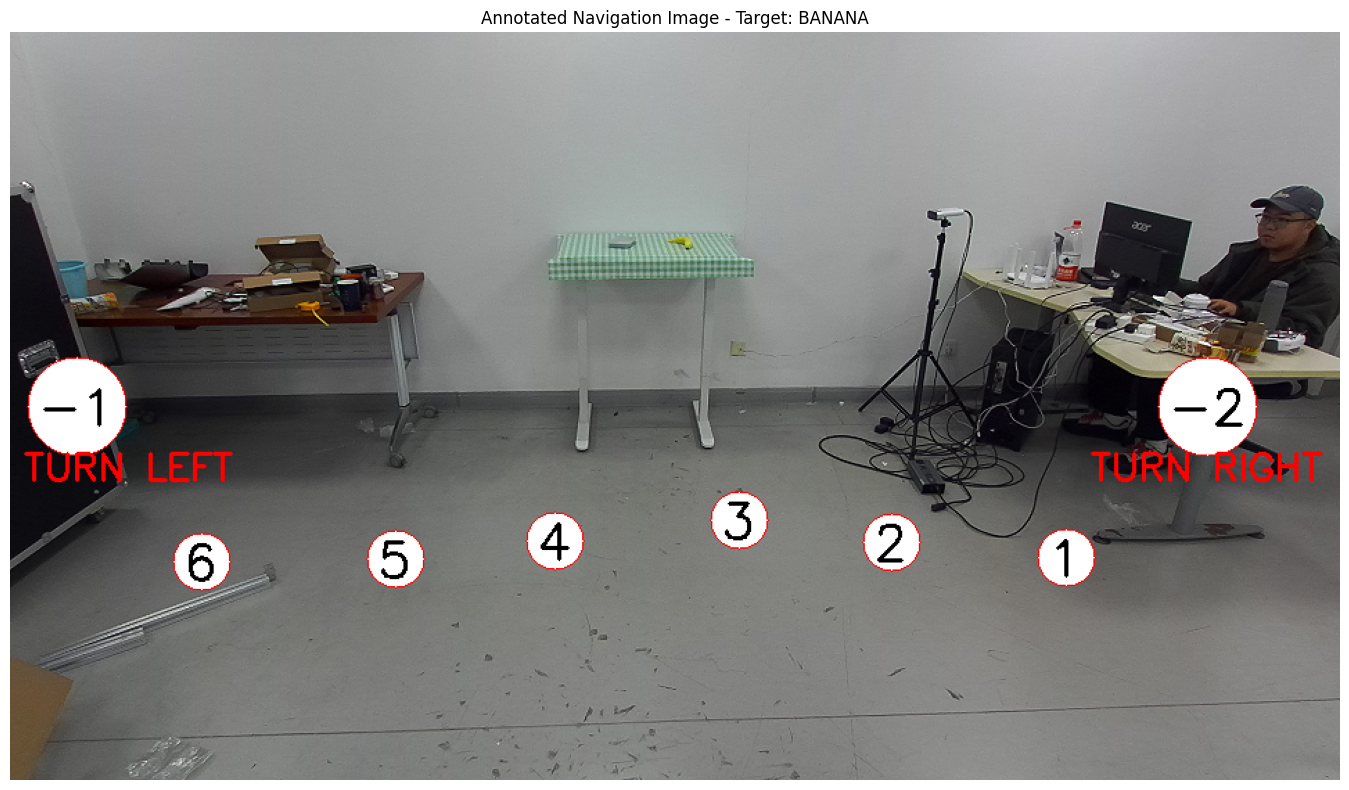

In [7]:
plt.figure(figsize=(15, 8))
plt.imshow(rgb_vis)
plt.title(f"Annotated Navigation Image - Target: {goal.upper()}")
plt.axis('off')
plt.tight_layout()
plt.show()

## 7. 构建VLM Prompt

In [8]:
# 构建当前迭代的prompt
iter_num = 1
prompt = agent._construct_prompt(num_actions=len(a_final_projected), iter=iter_num)

print("="*80)
print("当前迭代Prompt:")
print("="*80)
print(prompt)
print("="*80)
print(f"\nPrompt长度: {len(prompt)} 字符")

当前迭代Prompt:
--- Iteration 1 ---
Current observation: 6 available MOVE waypoints shown.

Now answer the 4 questions from the task briefing:
1. What do you see?
2. Which direction should you go?
3. Which action number?
4. {'action': <number>}

Prompt长度: 228 字符


## 8. 调用VLM进行推理

In [9]:
import time

print("\n发送请求到VLM...")
print(f"图像尺寸: {rgb_vis.shape}")
print(f"VLM历史长度: {agent.vlm_history_length} rounds")

# 记录开始时间
start_time = time.time()

# 调用VLM
try:
    response = agent.actionVLM.call_chat(
        history=agent.vlm_history_length,
        images=[rgb_vis],
        text_prompt=prompt
    )
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    print(f"\n推理时间: {inference_time:.2f} 秒")
    print("\n" + "="*80)
    print("VLM 响应:")
    print("="*80)
    print(response)
    print("="*80)
    
except Exception as e:
    print(f"\n错误: {e}")
    response = None


发送请求到VLM...
图像尺寸: (540, 960, 3)
VLM历史长度: 3 rounds



推理时间: 4.16 秒

VLM 响应:
1. What do you see?  
   I observe a room with two desks: one on the left with tools and boxes, and one on the right where a person is seated at a computer. A small table with a green-and-white checkered cloth is in the center. On top of that table, there’s a yellow object — possibly a banana — near the center of the room. There are six numbered MOVE waypoints (1–6) along the floor, indicating safe paths forward. Waypoints 1–3 are toward the right desk area; 4–6 are toward the left desk area.

2. Which direction should you go?  
   Based on prior knowledge, bananas are often placed on tables or desks. The yellow object on the central table looks promising. Since waypoint 4 is directly in front of the table, moving to it will bring me closest to the potential banana location without risking collision.

3. Which action number?  
   Action 4 is the best choice because it moves me straight toward the center table where the banana is likely located, prioritizing direc

## 9. 解析VLM响应并可视化选择的动作


解析结果:
  选择的动作编号: 4
  动作类型: 前进 (r=3.62m, θ=11.2°)
  描述: MOVE ACTION 4

生成带高亮的可视化图像...
[DEBUG] Projected action 1: r=3.92m, waypoint_r=3.13m, theta=-30.4°, px=(762, 379)
[DEBUG] Projected action 2: r=3.71m, waypoint_r=2.96m, theta=-17.6°, px=(636, 368)
[DEBUG] Projected action 3: r=3.81m, waypoint_r=3.04m, theta=-4.8°, px=(526, 352)
[DEBUG] Projected action 4: r=3.62m, waypoint_r=2.90m, theta=11.2°, px=(393, 367)
[DEBUG] Projected action 5: r=3.69m, waypoint_r=2.95m, theta=24.0°, px=(278, 380)
[DEBUG] Projected action 6: r=4.16m, waypoint_r=3.33m, theta=36.8°, px=(138, 382)
[DEBUG] _project_onto_image: 7 actions from _action_proposer, 6 projected, 1 skipped by _can_project


/tmp/ipykernel_1875390/13854231.py:39: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1875390/13854231.py:39: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/liujy/anaconda3/envs/model_server/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/liujy/anaconda3/envs/model_server/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


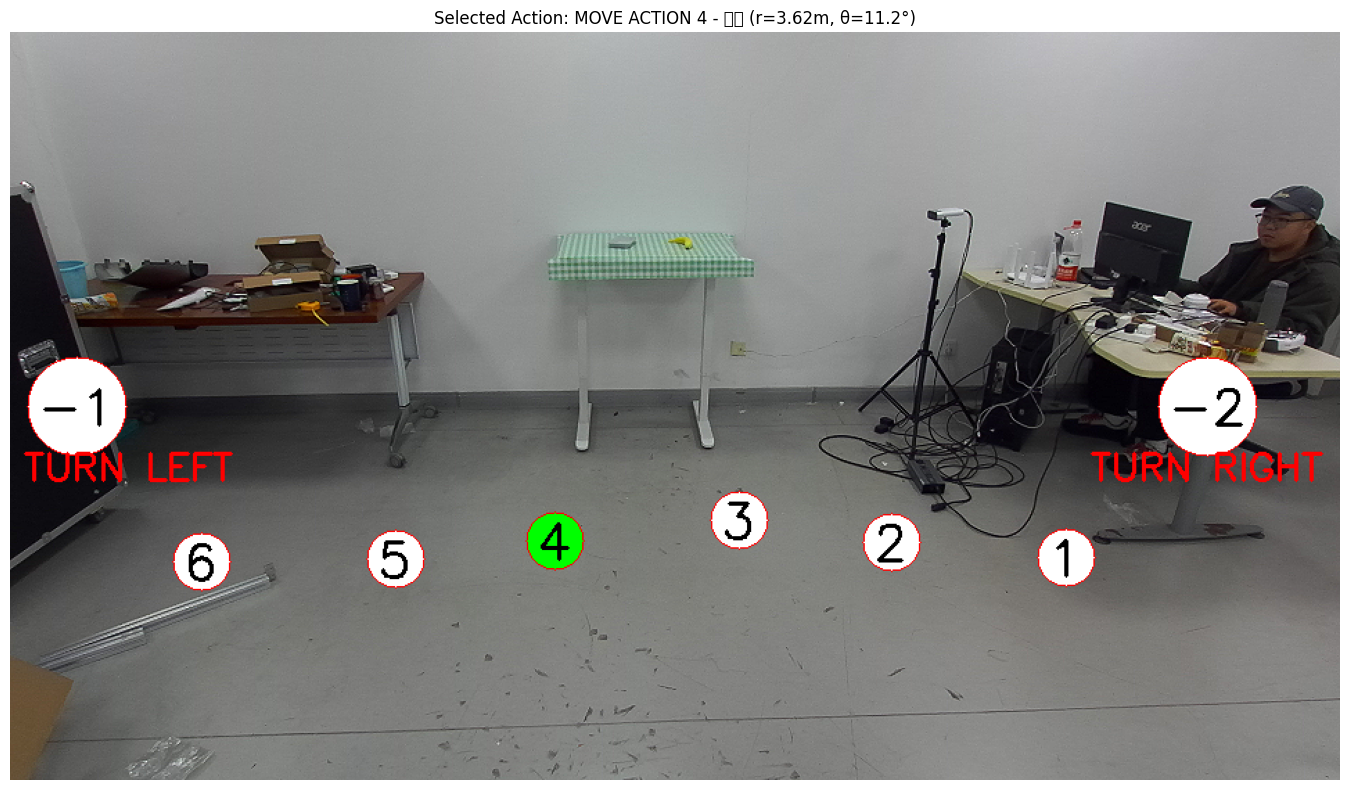


✓ 选中的动作用绿色圆圈高亮显示


In [10]:
if response:
    try:
        # 解析响应
        response_dict = agent._eval_response(response)
        action_number = int(response_dict['action'])
        
        print(f"\n解析结果:")
        print(f"  选择的动作编号: {action_number}")
        
        # 判断动作类型
        if action_number == -1:
            action_type = f"左转 {cfg['turn_angle_deg']}°"
            action_desc = "TURN LEFT"
        elif action_number == -2:
            action_type = f"右转 {cfg['turn_angle_deg']}°"
            action_desc = "TURN RIGHT"
        else:
            rev = {v: k for k, v in a_final_projected.items()}
            if action_number in rev:
                r, theta = rev[action_number]
                action_type = f"前进 (r={r:.2f}m, θ={np.degrees(theta):.1f}°)"
                action_desc = f"MOVE ACTION {action_number}"
            else:
                action_type = "无效动作"
                action_desc = "INVALID"
        
        print(f"  动作类型: {action_type}")
        print(f"  描述: {action_desc}")
        
        # 重新生成带高亮的可视化图像
        print(f"\n生成带高亮的可视化图像...")
        _, rgb_vis_highlighted = agent._projection(a_final, obs, chosen_action=action_number)
        
        # 显示高亮后的图像
        plt.figure(figsize=(15, 8))
        plt.imshow(rgb_vis_highlighted)
        plt.title(f"Selected Action: {action_desc} - {action_type}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ 选中的动作用绿色圆圈高亮显示")
        
    except Exception as e:
        print(f"\n解析响应失败: {e}")
else:
    print("\n无法解析响应")